In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

https://medium.com/@pennQuin/implementation-of-long-short-term-memory-lstm-81e35fa5ca54

In [84]:
from IPython.display import clear_output
import warnings

In [60]:
# download dataset from
# https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

import os
import subprocess
import zipfile
import shutil

# Criar diretório data se não existir
if not os.path.exists('data'):
    os.makedirs('data')
    print("Pasta 'data/' criada.")

# URL do dataset
url = "https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"

# Nome do arquivo zip
zip_file = "archive.zip"

try:
    # Baixar o arquivo usando wget
    print("Baixando o dataset...")
    wget_command = f"wget {url} -O {zip_file}"
    subprocess.run(wget_command, shell=True, check=True)
    print("Download concluído!")
    
    # Descompactar o arquivo
    if os.path.exists(zip_file):
        print(f"Descompactando {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('temp_imdb')
        
        # Mover o CSV para a pasta data/
        for file in os.listdir('temp_imdb'):
            if file.endswith('.csv'):
                src = os.path.join('temp_imdb', file)
                dst = os.path.join('data', file)
                shutil.move(src, dst)
                print(f"Arquivo {file} movido para data/")
        
        # Limpar arquivos temporários
        shutil.rmtree('temp_imdb')
        os.remove(zip_file)
        print("Arquivos temporários removidos.")
        
        clear_output(wait=True)
        print("'IMDB Dataset.csv' salvo com sucesso em data/")
    else:
        print(f"Erro: Arquivo {zip_file} não foi baixado corretamente.")
        
except subprocess.CalledProcessError as e:
    print(f"Erro ao baixar o arquivo: {e}")
except Exception as e:
    print(f"Erro durante o processamento: {e}")

'IMDB Dataset.csv' salvo com sucesso em data/


In [85]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [86]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [88]:
import re

def remove_html_tags(text):
    """
    Remove HTML tags from a string.
    """
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_special_characters(text):
    """
    Remove special characters from a string.
    """
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_extra_spaces(text):
    """
    Remove extra spaces from a string.
    """
    return re.sub(r'\s+', ' ', text).strip()
def to_lowercase(text):
    """
    Convert a string to lowercase.
    """
    return text.lower()
def preprocess_text(text):
    """
    Preprocess the input text by removing HTML tags, special characters,
    extra spaces, and converting to lowercase.
    """
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = to_lowercase(text)
    return text

df['clean_review'] = df['review'].apply(preprocess_text)
df['clean_review'].iloc[0]

'one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty pictur

In [89]:
# split into 25k train and 25k test
train = df[:25000]
test = df[25000:]

In [90]:
# reduce dataset to 2,5k train and 2,5k test
#train = train[:2500]
#test = test[:2500]

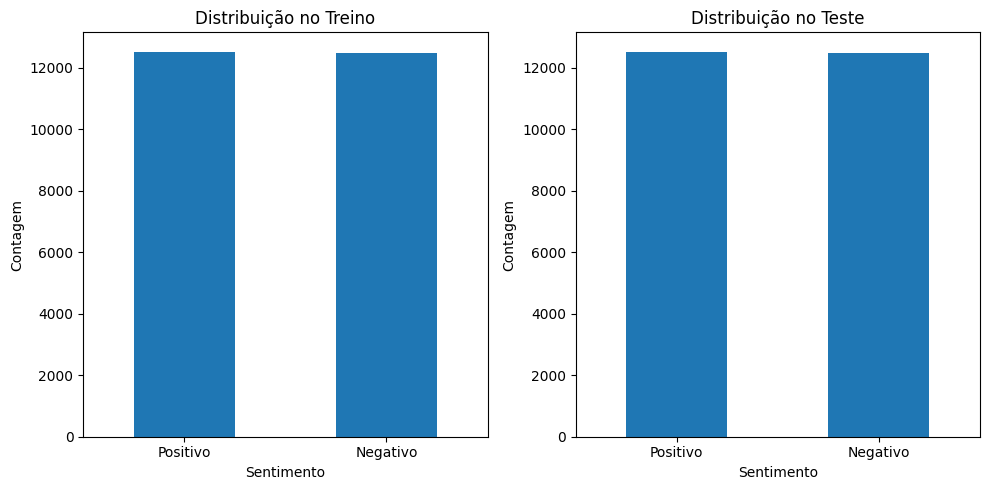

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# check distribution 
train['sentiment'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribuição no Treino')
ax[0].set_xlabel('Sentimento')
ax[0].set_ylabel('Contagem')
ax[0].set_xticklabels(['Positivo', 'Negativo'], rotation=0)

test['sentiment'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Distribuição no Teste')
ax[1].set_xlabel('Sentimento')
ax[1].set_ylabel('Contagem')
ax[1].set_xticklabels(['Positivo', 'Negativo'], rotation=0)
plt.tight_layout()
plt.show()

In [92]:
for i in range(5):
    print('Texto:', train['clean_review'].values[i])
    print('Sentimento:', train['sentiment'].values[i])
    print('---')

Texto: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty 

In [93]:
from keras_hub.tokenizers import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

https://javilopezcastillo.medium.com/sentiment-analysis-using-lstm-networks-a-deep-dive-into-textual-data-61cdd2e43dec

In [94]:
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))
    
    max_length = int(np.ceil(np.mean(review_length)))
    return max_length

In [95]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

VOCAB_SIZE = 10000

tokenizer = Tokenizer(num_words=VOCAB_SIZE)

tokenizer.fit_on_texts(train['clean_review'])

# Convert the text to sequences
train_sequences = tokenizer.texts_to_sequences(train['clean_review'])
test_sequences = tokenizer.texts_to_sequences(test['clean_review'])

In [96]:
len(train_sequences[1])

144

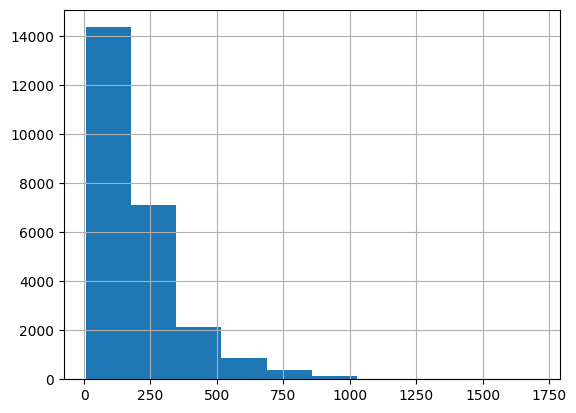

count    25000.000000
mean       210.378160
std        153.815341
min          8.000000
25%        116.000000
50%        159.000000
75%        256.000000
max       1704.000000
dtype: float64

In [97]:
review_len = [len(x) for x in train_sequences]
pd.Series(review_len).hist()
plt.show()
pd.Series(review_len).describe()

In [98]:
# get top 5% longest reviews
top_5_percent = np.percentile(review_len, 95)
print('Top 5%:', top_5_percent)

# all reviews with len above this number are just too big

Top 5%: 536.0499999999993


In [99]:
# Pad the sequences
MAX_LENGTH = int(np.floor(top_5_percent))

train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)
test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH)

# Convert the labels to binary
train_labels = np.where(train['sentiment'] == 'positive', 1, 0)
test_labels = np.where(test['sentiment'] == 'positive', 1, 0)

In [100]:
train_sequences

array([[   0,    0,    0, ...,  120, 3881,  503],
       [   0,    0,    0, ..., 1878,   71,  218],
       [   0,    0,    0, ...,   63,   14,  323],
       ...,
       [   0,    0,    0, ...,  225,  218,  229],
       [   0,    0,    0, ..., 3152,    2,  904],
       [   0,    0,    0, ...,  406,   49, 3311]], dtype=int32)

In [101]:
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from keras import regularizers
from keras.optimizers import Adam
from keras.layers import BatchNormalization 
from keras.callbacks import ModelCheckpoint

In [103]:
EMBED_DIM = 100
LSTM_OUT_NUM = 128

In [104]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=15,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [105]:
def now():
    from datetime import datetime
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [106]:
model1 = Sequential()

model1.add(Embedding(
    input_dim=tokenizer.num_words,
    output_dim=EMBED_DIM,
    input_length=MAX_LENGTH
))
model1.add(LSTM(LSTM_OUT_NUM))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/home/erlo/.localvenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [107]:
checkpoint = ModelCheckpoint(
    f'data/best_model_ff_{now()}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

history1 = model1.fit(
    train_sequences,
    train_labels,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
 46/313 ━━━━━━━━━━━━━━━━━━━━ 1:39 372ms/step - accuracy: 0.5164 - loss: 0.6915

KeyboardInterrupt: 

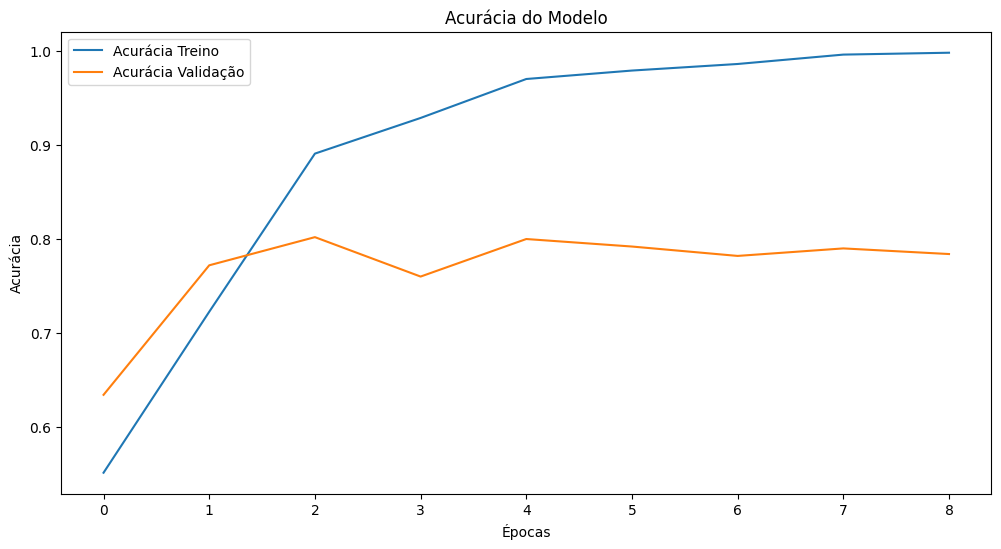

In [49]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(history1.history['accuracy'], label='Acurácia Treino')
plt.plot(history1.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [50]:
model2 = Sequential()

model2.add(Embedding(
    input_dim=tokenizer.num_words,
    output_dim=EMBED_DIM,
    input_length=MAX_LENGTH
))
model2.add(Bidirectional(LSTM(LSTM_OUT_NUM)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint = ModelCheckpoint(
    f'data/best_model_bi_{now()}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [51]:
history2 = model2.fit(
    train_sequences,
    train_labels,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.5040 - loss: 0.6931 - val_accuracy: 0.5220 - val_loss: 0.6877
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.5693 - loss: 0.6732 - val_accuracy: 0.7060 - val_loss: 0.6270
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.8169 - loss: 0.4939 - val_accuracy: 0.7820 - val_loss: 0.4548
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.9170 - loss: 0.2190 - val_accuracy: 0.7660 - val_loss: 0.4976
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.9766 - loss: 0.0856 - val_accuracy: 0.7960 - val_loss: 0.5570
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.9926 - loss: 0.0372 - val_accuracy: 0.7880 - val_loss: 0.6201
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - accuracy: 0.9994 - loss: 0.0167 - val_accuracy: 0.7700 - val_loss: 0.8914
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.9975 - loss: 0.0155 - val

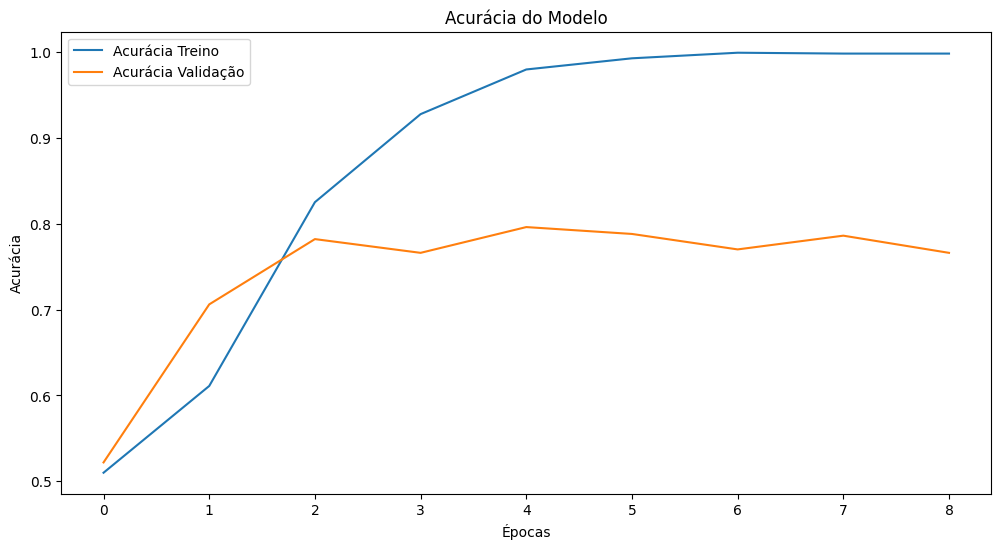

In [53]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(history2.history['accuracy'], label='Acurácia Treino')
plt.plot(history2.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negativo', 'Positivo'],
                yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

In [70]:
y_pred1 = model1.predict(test_sequences)
y_pred1 = np.where(y_pred1 > 0.5, 1, 0)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


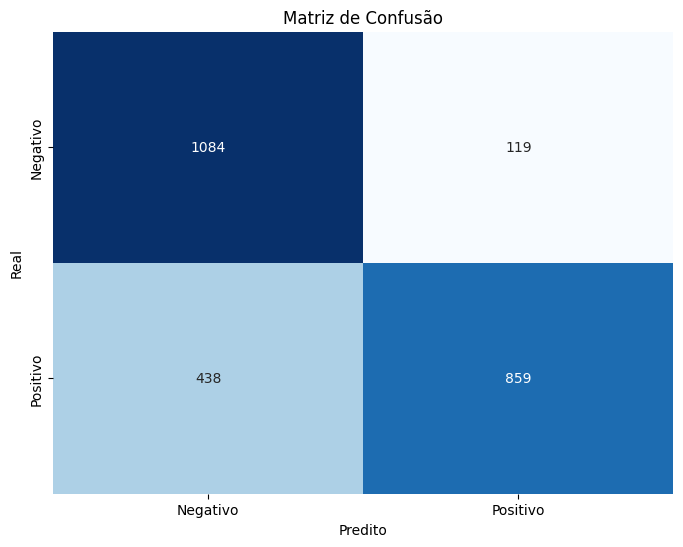

              precision    recall  f1-score   support

    Negativo       0.71      0.90      0.80      1203
    Positivo       0.88      0.66      0.76      1297

    accuracy                           0.78      2500
   macro avg       0.80      0.78      0.78      2500
weighted avg       0.80      0.78      0.77      2500



In [71]:
plot_confusion_matrix(test_labels, y_pred1)
print(classification_report(test_labels, y_pred1, target_names=['Negativo', 'Positivo']))

In [72]:
y_pred2 = model2.predict(test_sequences)
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step


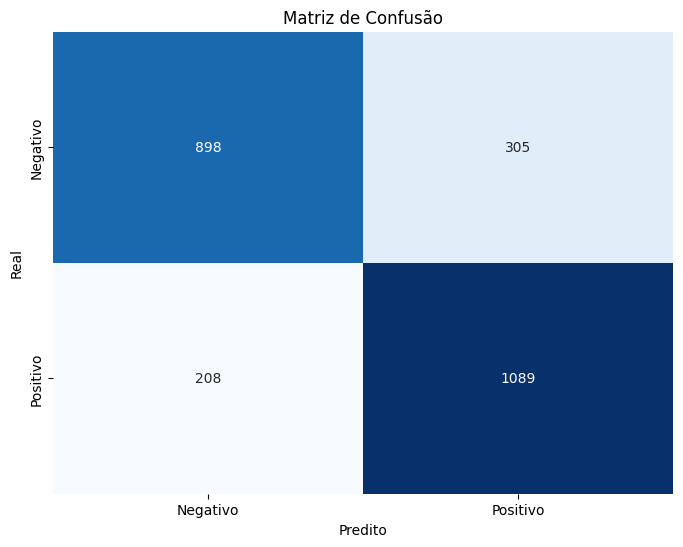

              precision    recall  f1-score   support

    Negativo       0.81      0.75      0.78      1203
    Positivo       0.78      0.84      0.81      1297

    accuracy                           0.79      2500
   macro avg       0.80      0.79      0.79      2500
weighted avg       0.80      0.79      0.79      2500



In [73]:
plot_confusion_matrix(test_labels, y_pred2)
print(classification_report(test_labels, y_pred2, target_names=['Negativo', 'Positivo']))

## Testing

In [55]:
from keras.models import load_model

loaded_model = load_model('data/best_model_2025-04-08 10:07:56.keras')
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 523, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,126,917 (11.93 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,084,612 (7.95 MB)

In [75]:
review = "Liked it a lot, very good movie"
review = "Bad movie I didn´t like it bad bad bad shit"
review = "This movie was fantastic and I loved it! Very well done and the actors were great. I would recommend it to everyone." 
review = "Shit movie I didn´t like it at all. The director was terrible and the plot made no sense. I would like to see him in person and tell how shit this movie was. 0 stars for this" 
review = preprocess_text(review)
review = tokenizer.texts_to_sequences([review])
review = pad_sequences(review, maxlen=MAX_LENGTH)
prediction = loaded_model.predict(review)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.07134356]]
